In [1]:
import sys
print(sys.version)

print(sys.path)

2.7.12 (default, Nov 20 2017, 18:23:56) 
[GCC 5.4.0 20160609]
['', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/home/mapr/.local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/home/mapr/.ipython']


In [230]:
import pyodbc
from pandas import *
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Initialize the ODBC connection to Drill

In [212]:
# initialize the connection
conn = pyodbc.connect("DSN=drill64", autocommit=True)
# Set unicode options so the ODBC driver returns column names and table contents as ASCII strings
conn.setdecoding(pyodbc.SQL_CHAR, encoding='utf-32le', to=str)
conn.setdecoding(pyodbc.SQL_WMETADATA, encoding='utf-32le', to=str)
cursor = conn.cursor()

# Select data from a MapR-DB table

In [273]:
s = "select * from dfs.`/apps/mqtt_records`"
df = pandas.read_sql(s, conn)
pd.set_option('display.max_columns', 200)
# infer data types for each column
df=df.apply(pd.to_numeric, errors='ignore')
print ("Loaded " + str(len(df.index)) + " rows and " + str(len(df.columns)) + " columns.")
df.head(5)

Loaded 143 rows and 170 columns.


,_id,AH1OaInDamper,AH1OaOutDamper,AH1ReturnDamper,AH2OaInDamper,AH2OaOutDamper,AH2ReturnDamper,AH3OaInDamper,AH3OaOutDamper,AH3ReturnDamper,AH4OaInDamper,AH4OaOutDamper,AH4ReturnDamper,AHU1ColdWaterValve,AHU1HotWaterValve,AHU1ReturnAirFanStatus,AHU1ReturnAirTemp,AHU1SupplyAirFanStatus,AHU1SupplyAirTemp,AHU2ColdWaterValve,AHU2HotWaterValve,AHU2ReturnAirFanStatus,AHU2ReturnAirTemp,AHU2SupplyAirFanStatus,AHU2SupplyAirTemp,AHU3ColdWaterValve,AHU3HotWaterValve,AHU3ReturnAirFanStatus,AHU3ReturnAirTemp,AHU3SupplyAirFanStatus,AHU3SupplyAirTemp,AHU4ColdWaterValve,AHU4HotWaterValve,AHU4ReturnAirFanStatus,AHU4ReturnAirTemp,AHU4SupplyAirFanStatus,AHU4SupplyAirTemp,Boiler1PumpStatus,Boiler2PumpStatus,BoilerFlowTemp,BoilerReturnTemp,BoilerStart,BuildingPower,CentralPlantOutsideAirTemp,CentralPlantRelativeHumidity,ChilledWaterBypassValve,Chiller1FlowTemp,Chiller1PumpStatus,Chiller1ReturnTemp,Chiller1Start,Chiller2FlowTemp,Chiller2PumpStatus,Chiller2ReturnTemp,Chiller2Start,DaylightSensor,FC10ColdWaterValve,FC10HotWaterValve,FC10Setpoint,FC10Temp,FC11ColdWaterValve,FC11HotWaterValve,FC11Setpoint,FC11Temp,FC12ColdWaterValve,FC12HotWaterValve,FC12Setpoint,FC12Temp,FC13ColdWaterValve,FC13HotWaterValve,FC13Setpoint,FC13Temp,FC14ColdWaterValve,FC14HotWaterValve,FC14Setpoint,FC14Temp,FC15ColdWaterValve,FC15HotWaterValve,FC15Temp,FC16ColdWaterValve,FC16HotWaterValve,FC16Setpoint,FC16Temp,FC17ColdWaterValve,FC17HotWaterValve,FC17Setpoint,FC17Temp,FC18ColdWaterValve,FC18HotWaterValve,FC18Setpoint,FC18Temp,FC19ColdWaterValve,FC19HotWaterValve,FC19Setpoint,FC19Temp,FC1ColdWaterValve,FC1HotWaterValve,FC1Temp,FC20ColdWaterValve,FC20HotWaterValve,FC20Setpoint,FC20Temp,FC21ColdWaterValve,FC21HotWaterValve,FC21Setpoint,FC21Temp,FC22ColdWaterValve,FC22HotWaterValve,FC22Setpoint,FC22Temp,FC23ColdWaterValve,FC23HotWaterValve,FC23Setpoint,FC23Temp,FC24ColdWaterValve,FC24HotWaterValve,FC24Setpoint,FC24Temp,FC26ColdWaterValve,FC26HotWaterValve,FC26Setpoint,FC26Temp,FC2ColdWaterValve,FC2HotWaterValve,FC2Temp,FC3ColdWaterValve,FC3HotWaterValve,FC3Temp,FC4ColdWaterValve,FC4HotWaterValve,FC4Temp,FC5ColdWaterValve,FC5HotWaterValve,FC5Temp,FC6ColdWaterValve,FC6HotWaterValve,FC6Temp,FC7ColdWaterValve,FC7HotWaterValve,FC7Setpoint,FC7Temp,FC8ColdWaterValve,FC8HotWaterValve,FC8Setpoint,FC8Temp,FC9ColdWaterValve,FC9HotWaterValve,FC9Setpoint,FC9Temp,OutsideAirTemp,Panel1Power,Panel2Power,Panel3Power,_Boiler1AboutToFail,_Boiler1RemainingUsefulLife,_Boiler2AboutToFail,_Boiler2RemainingUsefulLife,_Chiller1AboutToFail,_Chiller1RemainingUsefulLife,_Chiller2AboutToFail,_Chiller2RemainingUsefulLife,_day_number_of_week,_day_of_week_long,_month_long,_month_of_year,_quarter_of_year,_quarter_short,_week_key,_weekend,_year_key,timestamp
0,1523596677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,68.1,0,69.7,10.0,10.0,0,72.4,0,56.0,0.0,0.0,0,65.1,0,62.3,10.0,10.0,0,73.1,0,71.9,0,1,134.0,-3.2,0,130.8,70.7,3.9,147.7,50.0,0,51.6,0,49.8,1,50.4,1,1,0.0,0.0,0.0,73.6,0.0,0.0,0.0,73.7,0.0,0.0,0.0,72.8,0.0,0.0,0.0,-1,0.0,0.0,0.0,74.9,100.0,0.0,73.6,0.0,0.0,0.0,70.7,0.0,0.0,0.0,71.8,0.0,0.0,0.0,73.4,0.0,0.0,0.0,72.8,0.0,0.0,74.0,0.0,0.0,0.0,73.4,0.0,0.0,0.0,73.0,0.0,0.0,0.0,73.3,0.0,0.0,0.0,74.9,0.0,0.0,0.0,75.2,0.0,100.0,0.0,0.0,100.0,0.0,69.6,0.0,0.0,73.7,0.0,0.0,76.1,100.0,0.0,76.1,0.0,0.0,76.5,0.0,0.0,0.0,75.8,0.0,0.0,0.0,76.5,0.0,0.0,0.0,76.0,79.5,1.6,0.5,2.1,false,0,false,0,false,0,false,0,4,Thursday,April,4,2,Q2,15,False,2018,1523596677
1,1523596678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,67.9,0,69.7,10.0,10.0,0,71.9,0,56.9,0.0,0.0,0,64.9,0,62.3,10.0,10.0,0,73.0,0,71.9,0,1,134.0,-3.2,0,130.9,70.6,3.9,150.1,50.3,0,52.0,0,50.1,1,50.7,1,1,0.0,0.0,0.0,73.4,0.0,0.0,0.0,73.9,0.0,0.0,0.0,72.7,0.0,0.0,0.0,-1,0.0,0.0,0.0,75.2,100.0,0.0,73.7,0.0,0.0,0.0,70.9,0.0,0.0,0.0,71.3,0.0,0.0,0.0,73.9,0.0,0.0,0.0,73.4,0.0,0.0,74.0,0.0,0.0,0.0,73.6,0.0,0.0,0.0,73.3,0.0,0.0,0.0,73.4,0.0,0.0,0.0,74.6,0.0,0.0,0.0,75.1,0.0,100.0,0.0,0.0,100.0,0.0,69.6,0.0,0.0,73.4,0.0,0.0,76.4,0.0,0.0,75

# Visualize the time-series which we will attempt to forecast 

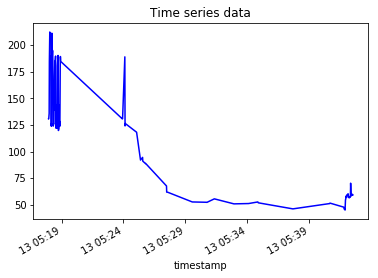

timestamp
2018-04-13 05:17:57    130.8
2018-04-13 05:17:58    130.9
2018-04-13 05:18:00    136.0
2018-04-13 05:18:01    184.6
2018-04-13 05:18:03    212.3
2018-04-13 05:18:04    184.5
2018-04-13 05:18:05    184.2
2018-04-13 05:18:07    189.8
2018-04-13 05:18:08    189.0
2018-04-13 05:18:09    124.2
dtype: float64

In [280]:
df = df.sort_values(by=['timestamp'])
df['timestamp']=pd.to_datetime(df['timestamp'], unit='s')
ts = pd.Series(df['BuildingPower'].values, index=df['timestamp'])
ts.head(100).plot(c='b', title="Time series data")
plt.show()
ts.head(10)

# Segment the time-series data into windows
We'll train the RNN model based on a narrow segment of the data recorded in opentsdb.

In [275]:
TS = np.array(ts[0:801])
num_periods = 20
f_horizon = 1

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
x_batches = x_data.reshape(-1, 20, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
y_batches = y_data.reshape(-1, 20, 1)
print (len(x_batches))
print (x_batches.shape)
print (y_batches.shape)

7
(7, 20, 1)
(7, 20, 1)


In [276]:
def test_data(series,forecast,num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 20, 1)
    testY = TS[-(num_periods):].reshape(-1, 20, 1)
    return testX,testY
X_test, Y_test = test_data(TS,f_horizon,num_periods)
print (X_test.shape)

(1, 20, 1)


In [277]:
import tensorflow as tf
import os
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

ImportError: No module named tensorflow

# Build the RNN model in Tensorflow

In [7]:
tf.reset_default_graph()
# num_periods = 20
inputs = 1
hidden = 100
output = 1

x = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, x, dtype=tf.float32)
learning_rate = 0.001
stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()

In [8]:
epochs = 1000

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={x: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={x: x_batches, y: y_batches})
            print (ep, "\tMSE:", mse)
            
    y_pred = sess.run(outputs, feed_dict={x: X_test})

0 	MSE: 535804.7
100 	MSE: 18145.705
200 	MSE: 11608.908
300 	MSE: 7767.0693
400 	MSE: 6437.749
500 	MSE: 6486.452
600 	MSE: 5602.07
700 	MSE: 6413.1055
800 	MSE: 4991.6934
900 	MSE: 4710.2256


# Compare forecasts with ground truth

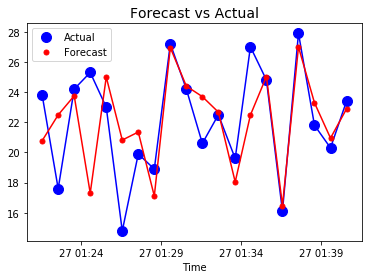

In [9]:
plt.title("Forecast vs Actual", fontsize = 14)
timestamps = df3['timestamp'][-len(pd.Series(np.ravel(Y_test))):].values
plt.plot(timestamps, pd.Series(np.ravel(Y_test)), "b-", markersize = 10)
plt.plot(timestamps, pd.Series(np.ravel(Y_test)), "bo", markersize = 10, label="Actual")
plt.plot(timestamps, pd.Series(np.ravel(y_pred)), "r-", markersize = 10)
plt.plot(timestamps, pd.Series(np.ravel(y_pred)), "r.", markersize = 10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()